<a href="https://colab.research.google.com/github/ronsegev98/Assignment_1_Group5/blob/main/Assignment_1_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1:

## Ron Segev, Noa Shalom, Dor Avrahami, Yam Almog


In [2]:
#import necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import plotly.express as px

from sklearn.model_selection import train_test_split


In [3]:
#access train from github
train_raw = pd.read_csv('https://raw.githubusercontent.com/ronsegev98/Assignment_1_Group5/main/train.csv')




In [ ]:
#Split into X,Y
X_train_raw = train_raw.drop(['count'], axis=1)
Y_train_raw = train_raw[['count']]

# Split the data into train and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_train_raw,Y_train_raw,test_size = 0.2, random_state = 42)

#put datetime on side for val
datetime_val = X_validation.iloc[:, 0]

X_train = X_train.iloc[:,1:]

X_validation = X_validation.iloc[:,1:]




-----------------------------
# 1. Exploration Phase



Our dataset consists of multiple datatypes. They are as follows:

datetime - time of rental - string

season - categorial

      - 1:winter

      - 2:spring

      - 3:summer

      - 4:fall

holiday - (Is it a bank holiday? If so: 1, else 0) - binary

workingday - (Is it a working day? If so: 1, else 0) - binary

weather - categorial

        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy

        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature - continuous

atemp - average temperature - continuous

humidity - continuous

windspeed - continuous

pollution - continuous

sunlight - continuous

traffic - continuous

count (Label) - continuous

In order to properly assess the given data, we will evaluate each data type separately.

# Continuous Features

### Statistics


Summary stats for each continuous feature


In [ ]:
# Selecting only continuous features
continuous_features = train_raw.select_dtypes(include=['float64', 'int64'])

# Columns to exclude from summary statistics
columns_to_exclude = ['season', 'holiday', 'workingday','weather']

# Exclude specified columns
continuous_features = continuous_features.drop(columns=columns_to_exclude, errors='ignore')

# Summary statistics for each continuous feature
summary_stats = continuous_features.describe().transpose().round(1)

# Print the summary statistics table
table = tabulate(summary_stats, headers='keys', tablefmt='pretty')
print("Summary Statistics for each continuous feature:")
print(table)


Summary Statistics for each continuous feature:
+-----------+--------+-------+-------+-----+------+-------+-------+-------+
|           | count  | mean  |  std  | min | 25%  |  50%  |  75%  |  max  |
+-----------+--------+-------+-------+-----+------+-------+-------+-------+
|   temp    | 8164.0 | 20.2  |  7.8  | 0.8 | 13.9 | 20.5  | 26.2  | 41.0  |
|   atemp   | 8164.0 | 23.7  |  8.5  | 0.8 | 16.7 | 24.2  | 31.1  | 45.5  |
| humidity  | 8164.0 | 61.8  | 19.3  | 0.0 | 47.0 | 62.0  | 77.0  | 100.0 |
| windspeed | 8164.0 | 12.8  |  8.2  | 0.0 | 7.0  | 13.0  | 17.0  | 57.0  |
| pollution | 8164.0 | 47.2  | 72.9  | 0.0 | 3.7  | 17.7  | 59.3  | 754.3 |
| sunlight  | 8164.0 | 20.2  |  7.8  | 0.8 | 13.9 | 20.5  | 26.2  | 41.0  |
|  traffic  | 8164.0 |  0.0  |  0.0  | 0.0 | 0.0  |  0.0  |  0.0  |  0.0  |
|   count   | 8164.0 | 191.3 | 181.1 | 1.0 | 41.0 | 145.0 | 285.0 | 970.0 |
+-----------+--------+-------+-------+-----+------+-------+-------+-------+


## Distribution of Continuous Variables

We will check  distribution of continuous variables in order to see which statistical methods we can use in preprocessing, as many require normal distribution.

In [ ]:
# Select numeric columns from train_raw
numeric_columns = train_raw.select_dtypes(include='number').columns

# Filter out non-continuous variables
continuous_columns = []
for column in numeric_columns:
    if train_raw[column].nunique() > 2:  # Adjust the threshold as needed
        continuous_columns.append(column)

# Initialize an empty list to store the results
results = []

# Iterate over each continuous column
for column in continuous_columns:
    # Make a copy of the column data and remove missing values
    data = train_raw[column].copy().dropna()

    # Perform Kolmogorov-Smirnov test
    stat, p = stats.kstest(data, 'norm', alternative='two-sided')
    results.append([column, stat, p])

# Display results in a table
headers = ["Column", "K-S Statistic", "p-value"]
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt='pretty'))

+-----------+--------------------+---------+
|  Column   |   K-S Statistic    | p-value |
+-----------+--------------------+---------+
|  season   | 0.8413447460685429 |   0.0   |
|  weather  | 0.8413447460685429 |   0.0   |
|   temp    | 0.9983785637828636 |   0.0   |
|   atemp   | 0.998209830693731  |   0.0   |
| humidity  | 0.9981626653601176 |   0.0   |
| windspeed | 0.877511023040509  |   0.0   |
| pollution | 0.7980655764419594 |   0.0   |
| sunlight  | 0.9983804004948836 |   0.0   |
|  traffic  |        0.5         |   0.0   |
|   count   | 0.9763571083377967 |   0.0   |
+-----------+--------------------+---------+


The code calculates the Kolmogorov-Smirnov for each continuous column in the raw dataset. The test compares the distribution of each column against a normal distribution. The test statistic (K-S statistic) measures the maximum difference between the cumulative distribution function (CDF) of the data and the CDF of the normal distribution.

The results are displayed in a table, including the column name, K-S statistic, and p-value. The K-S statistic represents the maximum distance between the empirical distribution function of the data and the theoretical distribution (in this case, the normal distribution). The p-value indicates the probability of observing a K-S statistic as extreme as the one obtained under the null hypothesis (the data follows a normal distribution).

Interpreting the results:

# Binary Variables

In [ ]:
#this function shows feature distribution

def show_feature_dist(df, feature):
    plt.figure(figsize=(3,3))
    value_counts = df[feature].value_counts().reset_index()
    value_counts.columns = [feature, 'Count']

    fig = px.bar(value_counts, x=feature, y='Count', color='Count',
                labels={feature: feature, 'Count': 'Distribution'},
                title=f'Distribution of {feature}')

    fig.show()

In [ ]:
categorial_feature_list = ['season', 'weather']

for feature in categorial_feature_list:
    show_feature_dist(train_raw,feature)

In [ ]:
binary_feature_list = ['holiday', 'workingday']

for feature in binary_feature_list:
    show_feature_dist(train_raw,feature)

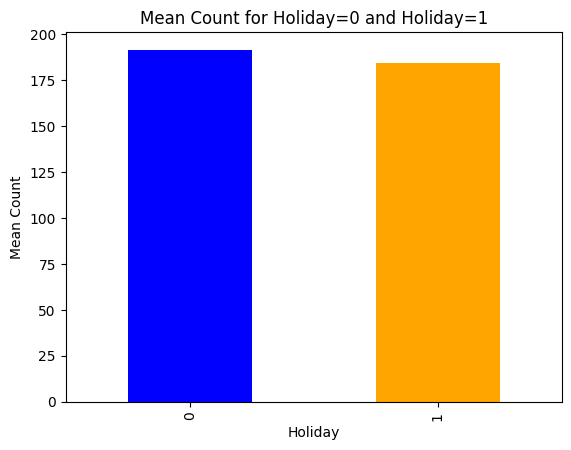

In [ ]:
# Group by 'holiday' and calculate mean 'count'
mean_count_by_holiday = df.groupby('holiday')['count'].mean()

# Plot bar plot
mean_count_by_holiday.plot(kind='bar', color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Holiday')
plt.ylabel('Mean Count')
plt.title('Mean Count for Holiday=0 and Holiday=1')

# Show the plot
plt.show()

## Correlation


For our first basic exploration of this dataset, we want to analyze correlation between features (and the label)


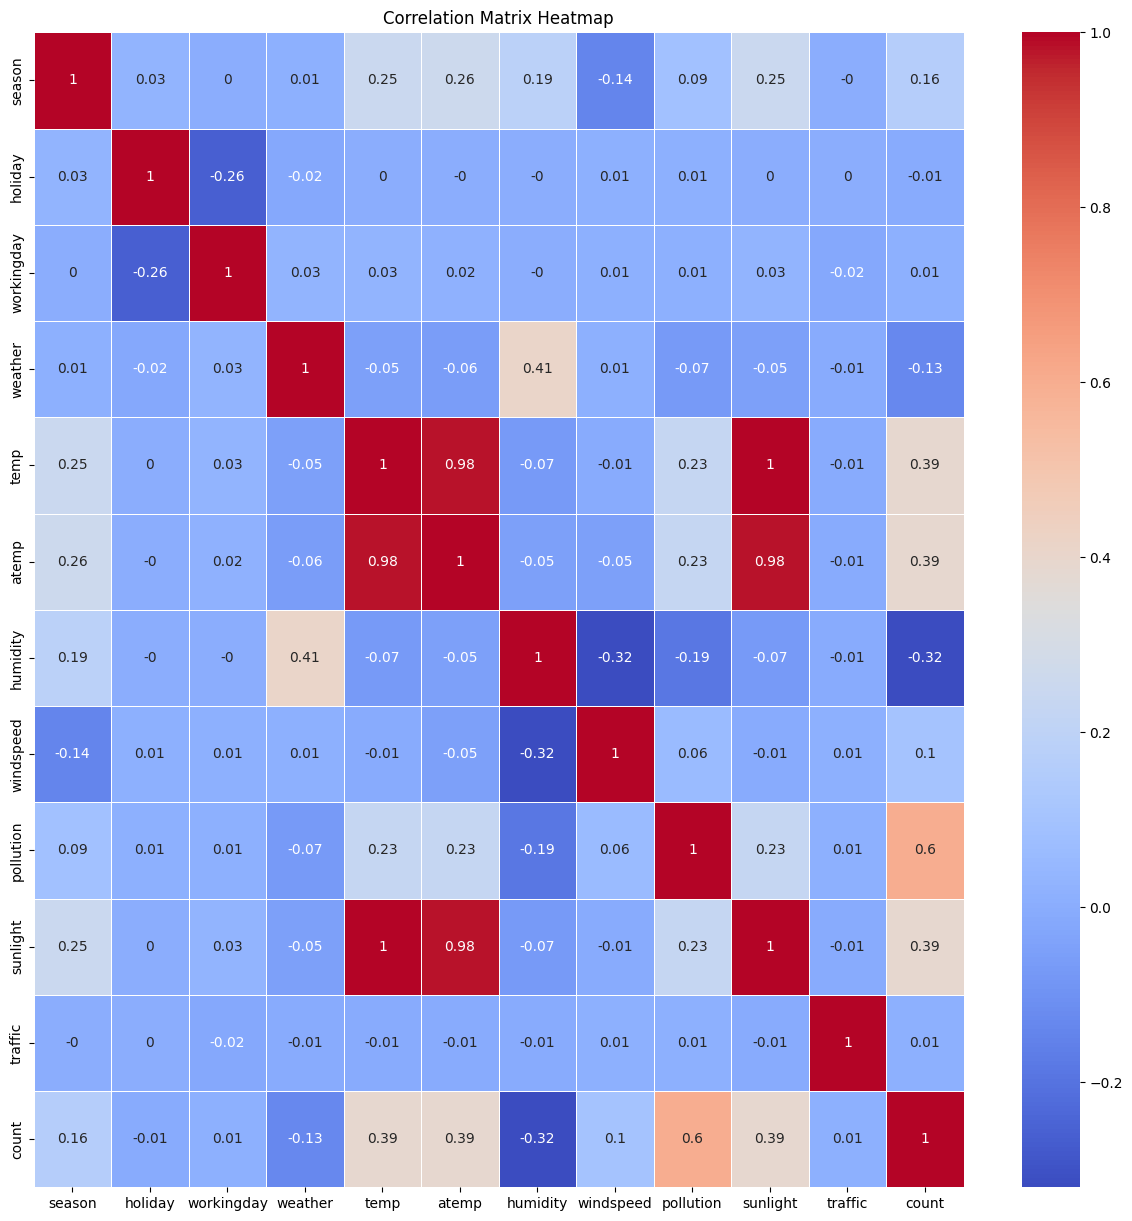

In [ ]:
# Correlation matrix heatmap
correlation_matrix = train_raw.corr(numeric_only=True).round(2)
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()